# Df + Lib

In [1]:
# df that have:
# user as numeric feature (from 0 to 5) 
# maingenre as numeric feature (from 0 to 16) --> tot 17 maingenri  
%store -r merge_unique_numain_df

In [2]:
# package that we need
import keras
from keras.models import Sequential
# we most use sequential model -> one layer after the other (sequence of layer)
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanAbsolutePercentageError

#for the CROSS-VALIDATION
from sklearn.model_selection import KFold

# essential
import numpy as np
import matplotlib.pyplot as plt

# not necessary in this case
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

# CROSS VALIDATION 

we want to try this approach in order to optimize our recomandation system, more in detail our NN

## TEST USER 1

In [3]:
# as a preliminary test in order to better understand cross validation, i try to develop it only for the user1
mask_u1=merge_unique_numain_df['User']==1
u1_df=merge_unique_numain_df[mask_u1]
u1_df.shape

(4669, 21)

In [4]:
#u1_df.isnull().sum()
# since we don't have null values we can procede in dividing the df

# TARGET_var
target='valence'

#FEATURES
features=[    'spotify_track_duration_minute', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'tempo', 'time_signature',
    'spotify_track_popularity', 'instrumentalness', 'liveness']

In [5]:
# now we can optain our variable x and y 

# TARGET
y=u1_df[target]

# FEATURES
x=u1_df[features]

In [6]:
# we need to standardize our features

# Standardizzazione delle feature
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [7]:
# Definition of the parameters of the kfold cross-validation
# the folds are generally 5 or 10 
# the folds indicate in wich part we divide the df, each folds have a similar dimension 
# in this way:

#Run k iterations of training and validation:

#Iteration 1: Trained on Fold 2-3-4-5, valid on Fold 1
#Iteration 2: Trained on Fold 1-3-4-5, valid on Fold 2
#And so on, until you have used each fold as a validation set once.

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [8]:
# now we can define a function in order to build our NN

def create_model():
        model = Sequential()
        model.add(Dense(32, activation='relu', input_shape=(x_scaled.shape[1],)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))  # Output --> valence
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',metrics=['mae'])
        return model

In [9]:
# we define a list in order to save the error for each fold
mse_scores=[]

In [10]:
# now we have to divide the df in train and test, following the cross validatin process
for train_index, val_index in kf.split(x_scaled):
    X_train, X_val = x_scaled[train_index], x_scaled[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [11]:
# now we can build and create the model
model_u1 = create_model()
h_model_u1=model_u1.fit(X_train, y_train, epochs=20,validation_split=0.2, batch_size=32, verbose=0)

c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model_u1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981 (11.65 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,988 (7.77 KB)

In [13]:
#evaluation of the model
y_pred = model_u1.predict(X_val).flatten()
mse = mean_squared_error(y_val, y_pred)
mse_scores.append(mse)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [14]:
# Calcolo della media e deviazione standard del MSE
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'MSE medio: {mean_mse:.4f}')
print(f'Deviazione standard del MSE: {std_mse:.4f}')

MSE medio: 0.0333
Deviazione standard del MSE: 0.0000


This is the result of the mae that we obtain from the 'basic' methond **train/test split**

MSE user1: 0.03147273977545834 

We don't see significant improvements from a MSE pov, this is normal because the real **AIM of this procedure** is to obtain estimation that are **more robust**, so we don't have to evaluete the result of this metrics in order to compare the two method.

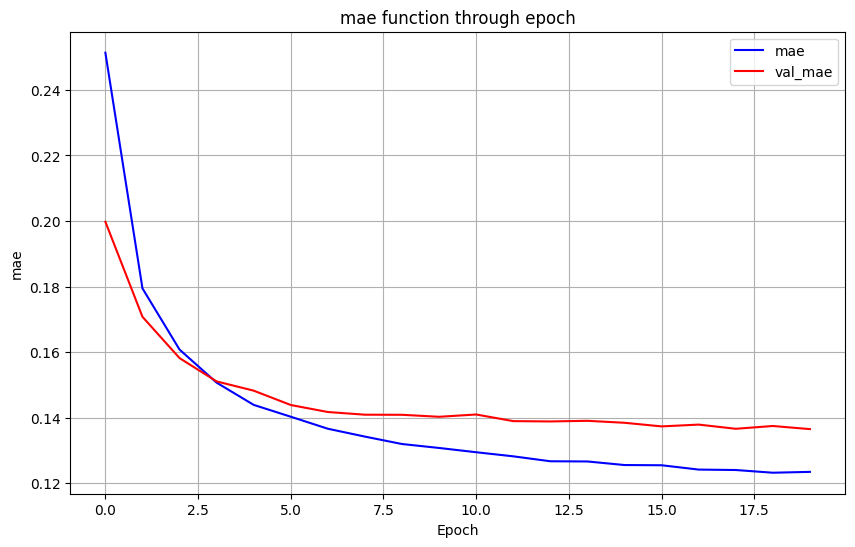

In [15]:
# we can try to perform some plots
plt.figure(figsize=(10,6))
plt.plot(h_model_u1.history['mae'],color='blue',label='mae')
plt.plot(h_model_u1.history['val_mae'],color='red',label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.title('mae function through epoch')
plt.legend()
plt.grid()
plt.show()

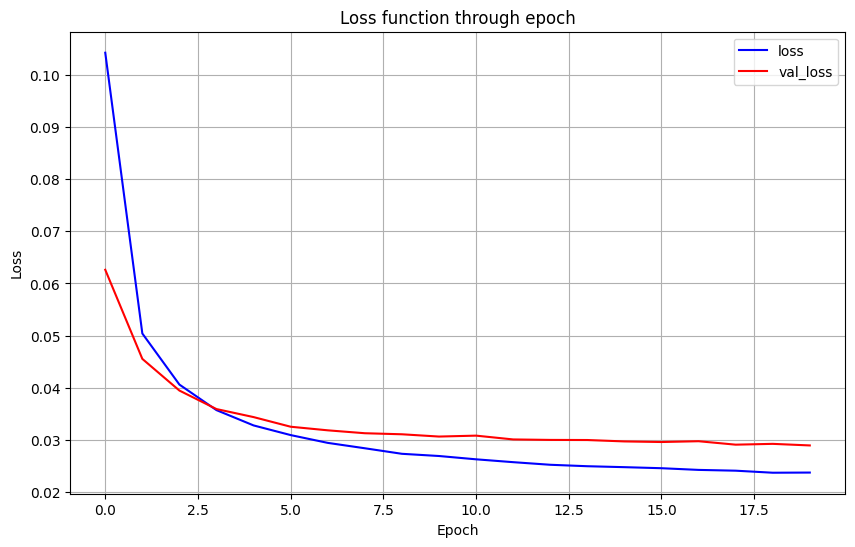

In [17]:
plt.figure(figsize=(10,6))
plt.plot(h_model_u1.history['loss'],color='blue',label='loss')
plt.plot(h_model_u1.history['val_loss'],color='red',label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function through epoch')
plt.legend()
plt.grid()
plt.show()

### So, how can we evaluate if one method is better that the other ?

1) Evaluate the std, if the std is lesser, this means that our esimation is better than the other since we have less oscillation 

2) Metrics (mse, mae)

3) Statistics test 

4) Learning rate

In [19]:
# if we look at the std for example in the model with the cross validation, we see:
print(f'MSE medio: {mean_mse:.4f}')
print(f'Deviazione standard del MSE: {std_mse:.4f}') 

# we have 0 std --> WE HAVE TO CHECK IT ALSO FROM THE STANDARD METHOD IN THE NN FILE

MSE medio: 0.0333
Deviazione standard del MSE: 0.0000
